<a href="https://colab.research.google.com/github/jason-zl190/deeplearning/blob/master/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [0]:
# Bicubic Downsample For Oxford Dogs
def bicubic_kernel(x, a=-0.5):
  """https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html#bicubic"""
  if abs(x) <= 1:
    return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
  elif 1 < abs(x) and abs(x) < 2:
    return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
  else:
    return 0

def build_filter(factor):
  size = factor*4
  k = np.zeros((size))
  for i in range(size):
    x = (1/factor)*(i- np.floor(size/2) +0.5)
    k[i] = bicubic_kernel(x)
  k = k / np.sum(k)
  # make 2d
  k = np.outer(k, k.T)
  k = tf.constant(k, dtype=tf.float32, shape=(size, size, 1, 1))
  return tf.concat([k, k, k], axis=2)

def apply_bicubic_downsample(x, filter, factor):
  """Downsample x by a factor of factor, using the filter built by build_filter()
  x: a rank 4 tensor with format NHWC
  filter: from build_filter(factor)
  factor: downsampling factor (ex: factor=2 means the output size is (h/2, w/2))
  """
  # using padding calculations from https://www.tensorflow.org/api_guides/python/nn#Convolution
  filter_height = factor*4
  filter_width = factor*4
  strides = factor
  pad_along_height = max(filter_height - strides, 0)
  pad_along_width = max(filter_width - strides, 0)
  # compute actual padding values for each side
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  # apply mirror padding
  x = tf.pad(x, [[0,0], [pad_top,pad_bottom], [pad_left,pad_right], [0,0]], mode='REFLECT')
  # downsampling performed by strided conv
  x = tf.nn.depthwise_conv2d(x, filter=filter, strides=[1,strides,strides,1], padding='VALID')
  return x

# normalize
def normalize(image):
    image = tf.cast(image, dtype=tf.float32)
    return (image-tf.math.reduce_min(image))/(tf.math.reduce_max(image)-tf.math.reduce_min(image))

In [0]:
class MySRResNet(tf.keras.Model):
  def __init__(self):
    super(MySRResNet, self).__init__(name='')
    
    # k9n64s1
    self.conv1 = tf.keras.layers.Conv2D(64, 9, 1, padding='same')
    self.prelu1 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    
    # B residual blocks
    # conv2_1, k3n64s1
    self.conv21a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn21a = tf.keras.layers.BatchNormalization()
    self.prelu21a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv21b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn21b = tf.keras.layers.BatchNormalization()
    
    self.x21_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x21 = tf.keras.layers.BatchNormalization()

     
    # conv2_2, k3n64s1
    self.conv22a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn22a = tf.keras.layers.BatchNormalization()
    self.prelu22a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv22b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn22b = tf.keras.layers.BatchNormalization()
    
    self.x22_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x22 = tf.keras.layers.BatchNormalization()

    # conv2_3, k3n64s1
    self.conv23a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn23a = tf.keras.layers.BatchNormalization()
    self.prelu23a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv23b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn23b = tf.keras.layers.BatchNormalization()
    
    self.x23_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x23 = tf.keras.layers.BatchNormalization()


    # conv2_4, k3n64s1
    self.conv24a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn24a = tf.keras.layers.BatchNormalization()
    self.prelu24a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv24b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn24b = tf.keras.layers.BatchNormalization()
    
    self.x24_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x24 = tf.keras.layers.BatchNormalization()


    # conv2_5, k3n64s1 -- end of B residual block
    self.conv25a = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn25a = tf.keras.layers.BatchNormalization()
    self.prelu25a = tf.keras.layers.PReLU(alpha_initializer='zeros')
    self.conv25b = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.bn25b = tf.keras.layers.BatchNormalization()
    
    self.x25_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x25 = tf.keras.layers.BatchNormalization()


    # conv3, k3n64s1
    self.conv3 = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.x3_append = tf.keras.layers.Conv2D(64, 1, 1, padding='same', use_bias=False)
    self.bn_x3 = tf.keras.layers.BatchNormalization()

    # conv4_1, k3n256s1
    self.conv41 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu41 = tf.keras.layers.PReLU(alpha_initializer='zeros')
    # conv4_2
    self.conv42 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.prelu42 = tf.keras.layers.PReLU(alpha_initializer='zeros')

    # conv5, k9n3s1
    self.conv5 = tf.keras.layers.Conv2D(3, 9, 1, padding='same')
    

  def call(self, input_tensor, training=False):
    input_tensor = self.conv1(input_tensor)
    input_tensor = self.prelu1(input_tensor)
    
     # B residual blocks
    # conv2_1, k3n64s1
    x = self.conv21a(input_tensor)
    x = self.bn21a(x)
    x = self.prelu21a(x)                          
    x = self.conv21b(x)                         
    x = self.bn21b(x)                 
    x_append = self.x21_append(input_tensor)
    x += x_append                   
    x21 = self.bn_x21(x)                 

     
    # conv2_2, k3n64s1
    x = self.conv22a(x21)          
    x = self.bn22a(x)               
    x = self.prelu22a(x)                 
    x = self.conv22b(x)          
    x = self.bn22b(x)                  
    x_append = self.x22_append(x21)
    x += x_append                   
    x22 = self.bn_x22(x)                 

    # conv2_3, k3n64s1
    x = self.conv23a(x22)         
    x = self.bn23a(x)                
    x = self.prelu23a(x)              
    x = self.conv23b(x)          
    x = self.bn23b(x)                
    
    x_append = self.x23_append(x22)
    x += x_append           
    x23 = self.bn_x23(x)                


    # conv2_4, k3n64s1
    x = self.conv24a(x23)           
    x = self.bn24a(x)                
    x = self.prelu24a(x)             
    x = self.conv24b(x)          
    x = self.bn24b(x)                
    
    x_append = self.x24_append(x23)
    x += x_append              
    x24 = self.bn_x24(x)                


    # conv2_5, k3n64s1 -- end of B residual block
    x = self.conv25a(x24)           
    x = self.bn25a(x)                
    x = self.prelu25a(x)             
    x = self.conv25b(x)          
    x = self.bn25b(x)                
    
    x_append = self.x25_append(x24)
    x += x_append              
    x25 = self.bn_x25(x)                


    # conv3, k3n64s1
    x = self.conv3(x25)        
    x = self.bn3(x)                
    x_append = self.x3_append(input_tensor)
    x += x_append
    x = self.bn_x3(x)      


    # conv4_1, k3n256s1
    x = self.conv41(x) 
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu41(x)             
    # conv4_2
    x = self.conv42(x)
    x = tf.nn.depth_to_space(x, block_size=2)               
    x = self.prelu42(x)             

    # conv5, k9n3s1
    x = self.conv5(x)         
    return x

generator = MySRResNet()

In [0]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__(name='')
    
    # k3n64s1
    self.conv1 = tf.keras.layers.Conv2D(64, 3, 1, padding='same')
    self.leakyrelu1 = tf.keras.layers.LeakyReLU(alpha=0.2)
    
    #  blocks
    # conv2_1, k3n64s2
    self.conv21 = tf.keras.layers.Conv2D(64, 3, 2, padding='same')
    self.bn21 = tf.keras.layers.BatchNormalization()
    self.leakyrelu21 = tf.keras.layers.LeakyReLU(alpha=0.2)
     
    # conv2_2, k3n128s1
    self.conv22 = tf.keras.layers.Conv2D(128, 3, 1, padding='same')
    self.bn22 = tf.keras.layers.BatchNormalization()
    self.leakyrelu22 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_3, k3n128s2
    self.conv23 = tf.keras.layers.Conv2D(128, 3, 2, padding='same')
    self.bn23 = tf.keras.layers.BatchNormalization()
    self.leakyrelu23 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_4, k3n256s1
    self.conv24 = tf.keras.layers.Conv2D(256, 3, 1, padding='same')
    self.bn24 = tf.keras.layers.BatchNormalization()
    self.leakyrelu24 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_5, k3n256s2
    self.conv25 = tf.keras.layers.Conv2D(256, 3, 2, padding='same')
    self.bn25 = tf.keras.layers.BatchNormalization()
    self.leakyrelu25 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_6, k3n512s1
    self.conv26 = tf.keras.layers.Conv2D(512, 3, 1, padding='same')
    self.bn26 = tf.keras.layers.BatchNormalization()
    self.leakyrelu26 = tf.keras.layers.LeakyReLU(alpha=0.2)

    # conv2_7, k3n512s2 -- end of B residual block
    self.conv27 = tf.keras.layers.Conv2D(512, 3, 2, padding='same')
    self.bn27 = tf.keras.layers.BatchNormalization()
    self.leakyrelu27 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(1024)
    self.leakyrelu3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.dense2 = tf.keras.layers.Dense(1, activation='softmax')
    

  def call(self, input_tensor, training=False):
    input_tensor = self.conv1(input_tensor)
    input_tensor = self.leakyrelu1(input_tensor)
    
    # conv2_1, k3n64s2
    x = self.conv21(input_tensor)
    x = self.bn21(x)
    x = self.leakyrelu21(x)                          
     
    # conv2_2, k3n128s1
    x = self.conv22(x)          
    x = self.bn22(x)               
    x = self.leakyrelu22(x)                        

    # conv2_3, k3n128s2
    x = self.conv23(x)         
    x = self.bn23(x)                
    x = self.leakyrelu23(x)                         

    # conv2_4, k3n256s1
    x = self.conv24(x)           
    x = self.bn24(x)                
    x = self.leakyrelu24(x)            

    # conv2_5, k3n256s2
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    # conv2_6, k3n512s1
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    # conv2_7, k3n512s2 -- end of B residual block
    x = self.conv25(x)           
    x = self.bn25(x)                
    x = self.leakyrelu25(x)            

    x = self.flatten(x)
    x = self.dense1(x)
    x = self.leakyrelu3(x)
    x = self.dense2(x)

    return x

discriminator = Discriminator()

In [0]:
#sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

In [0]:
#Load VGG model
from tensorflow.keras import models, optimizers, metrics
from tensorflow.keras.applications.vgg19 import preprocess_input
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape = [32,32,3])
vgg.trainable = False
content_layers = 'block5_conv2'

lossModel = models.Model([vgg.input], vgg.get_layer(content_layers).output, name = 'vggL')

def _lossMSE(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

def _lossVGG(y_true, y_pred):
  Xt = preprocess_input(y_pred*255)
  Yt = preprocess_input(y_true*255)
  vggX = lossModel(Xt)
  vggY = lossModel(Yt)
  return 0.006*tf.reduce_mean(tf.square(vggY-vggX))

def _lossGAN(y_pred):
  """
    params:
    X: hr_pred
  """
  return tf.sum(-1*tf.math.log(D(y_pred)))

def lossPerceptual(y_true, y_pred):
  loss_vgg = _lossVGG(y_true, y_pred)
  loss_gan = _lossGAN(y_pred)
  return loss_vgg + 0.001*loss_gan

In [0]:
def ssim(x, y, max_val=1.0):
  return tf.image.ssim(x, y, max_val)

def psnr(x, y, max_val=1.0):
  return tf.image.psnr(x, y, max_val)

In [0]:
# optimizer = adam
# loss = lossPerceptual
# metrics = [ssim, psnr]
# model.compile(optimizer=optimizer,
#               loss=loss,
#               metrics=metrics)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [8]:
dim = tf.constant([224, 224], dtype=tf.int32)
batch_size = 32
# create the bicubic kernel. This can be reused in multiple downsample operations
k = build_filter(factor=4)
ds = tfds.load('oxford_iiit_pet')

# bulit dataset
ds_train = ds['train'].map(lambda ele: tf.image.resize_with_crop_or_pad(ele['image'], 224, 224))
ds_train = ds_train.map(lambda x: tf.divide(tf.cast(x, tf.float32), 255))
ds_train = ds_train.repeat().batch(batch_size).prefetch(16)
ds_train = ds_train.map(lambda x: (apply_bicubic_downsample(x, filter=k, factor=4), x))
ds_train = ds_train.map(lambda x, y:(normalize(x), normalize(y)))

ds_test = ds['test'].map(lambda ele: tf.image.resize_with_crop_or_pad(ele['image'], 224, 224))
ds_test = ds_test.map(lambda x: tf.divide(tf.cast(x, tf.float32), 255))
ds_test = ds_test.repeat().batch(batch_size).prefetch(16)
ds_test = ds_test.map(lambda x: (apply_bicubic_downsample(x, filter=k, factor=4), x))
ds_test = ds_test.map(lambda x, y:(normalize(x), normalize(y)))


num_epochs = 5
train_count = 3669
validation_count = 3680
# history = model.fit(ds_train, 
#                     steps_per_epoch=int(train_count/batch_size), 
#                     validation_data=ds_test, 
#                     validation_steps=int(validation_count/batch_size), 
#                     epochs=num_epochs)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/1.1.0. Subsequent calls will reuse this data.


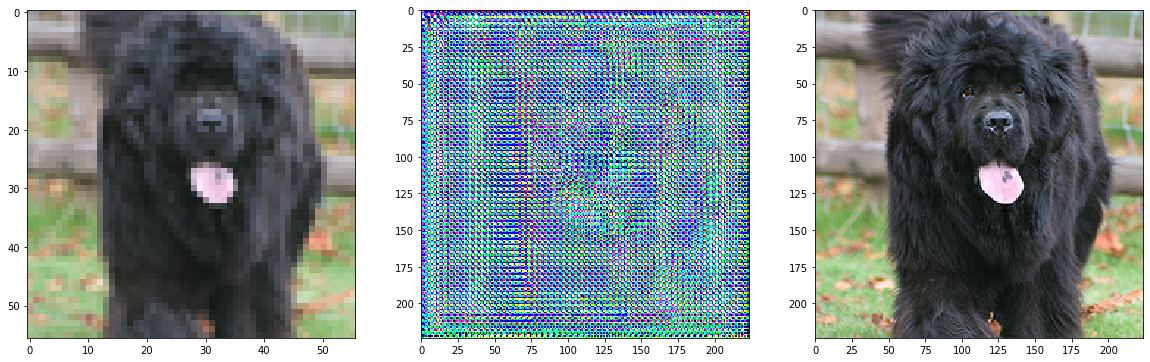

In [22]:
for lr, hr in ds_train: break

hr_pred = generator.predict(lr)

fig,ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(lr[0])
ax[1].imshow(hr_pred[0]*255)
ax[2].imshow(hr[0])


plt.show()

In [0]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    lr, hr = data
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr, training=True)

      real_output = discriminator(hr, training=True)
      fake_output = discriminator(generated_images, training=True)

      disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss = generator_loss(fake_output)
      content_loss = _lossMSE(hr, generated_images)
      sr_loss = content_loss + 0.001*gen_loss

    gradients_of_generator = gen_tape.gradient(sr_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
import time
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             lr)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           lr)



In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
train(ds_train, num_epochs)